
Mean of Erosion Volsum over count: 0.599597685773585
Standard Deviation of Erosion Volsum over count: 0.25038060518582317
Mean Squared Error: 0.05152349171368669
Root Mean Squared Error: 0.22698786688650716
R^2 Score: 0.1623232848675492


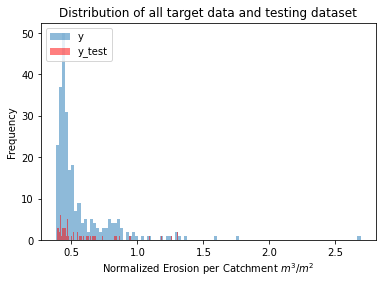

In [1]:
import RF_lib.RF_utils as rfut
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
import pandas as pd
import seaborn as sns

# Load your data (modify this part with real data loading)
csv_fn = r"Y:\ATD\GIS\East_Troublesome\Watershed Statistical Analysis\Watershed Stats\Hillslopes\Stream Clipped Hillslopes Pruned\Hillslope_Stats_Combined 050224.csv"
variables_to_exclude = ['ID', 'Erosion mean', "Category",	"OBJECTID", "Deposition mean",	"Deposition stdev",	"Erosion stdev", "Watershed",
                    "Deposition mean Masked",	"Deposition stdev Masked",	"Erosion mean Masked",	"Erosion stdev Masked", 'Erosion Volsum Masked',	
                    'Erosion Volsum Masked Count',	'Erosion Volsum over count', 'Deposition Volsum Masked',	'Deposition Volsum Masked Count',  
                    'perimeter', "width", "length", "Terrain Ruggedness Index",  "Aspect Mean", "Aspect std", 
                      "Curvature", "width_over_length","area",  
                    #   "dummy",  
                    # "Slope std",  "Max Int 60 min", "Accumulated Precipitation", "dNBR Mean",
                    # "Flow Accumulation",  "Mulch Coverage %", "% Bare Earth", "Slope Mean",
                    ] #

y_field = 'Erosion Volsum over count'
watershed_values = None

def load_data(file_path, exclude_vars, y_var):
    data = pd.read_csv(file_path)
    #drop rows where Erosion Volsum Masked Count is less than 10
    data = data[data['Erosion Volsum Masked Count'] >= 1]
    X = data.drop(columns=exclude_vars)
    y = data[y_var].dropna()
    #drop rows where y contains NaN
    y = y.dropna()
    X = X.loc[y.index]
    X = pd.get_dummies(X)  # Convert categorical columns to dummy variables
    y = y[y <= -0.196]
    X = X.loc[y.index]
    #log transform y
    y = np.abs(y)
    return X, y


# Load and prepare data
# Using specific watershed data if watershed_value is defined, else load all data
X, y = load_data(csv_fn, variables_to_exclude, y_field)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=350, max_depth=18, min_samples_split=5, random_state=42)
#model = rfut.random_hyperparam_opt_RF(X_train, X_test, y_train, y_test)
#model = rfut.grid_hyperparam_opt_RF(X_train, y_train)
#model = rfut.bayesian_hyperparam_opt_RF(X_train, X_test, y_train, y_test)
#model = rfut.random_hyperparam_opt_XGB(X_train, X_test, y_train, y_test)

model.fit(X_train, y_train)
print(f"\nMean of {y_field}: {y_test.mean()}")
print(f"Standard Deviation of {y_field}: {y_test.std()}")
r2, mse, predictions = rfut.evaluate_model(model, X_test, y_test)


from RF_lib.RF_utils import plot_y_ytest_histogram
plot_y_ytest_histogram(y, y_test)


In [ ]:
from RF_lib.RF_feature_importance import robust_feature_ranking

model_performance, shap_dict, rfe_dict = robust_feature_ranking(model, X, y, perform_rfe = True, plot = True)

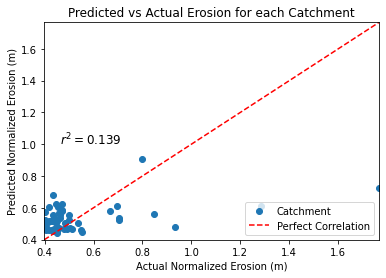

In [ ]:
from RF_lib.RF_utils import plot_predictions

mean_score = np.mean([r['score'] for r in model_performance])
plot_predictions(y_test, predictions, mean_score)

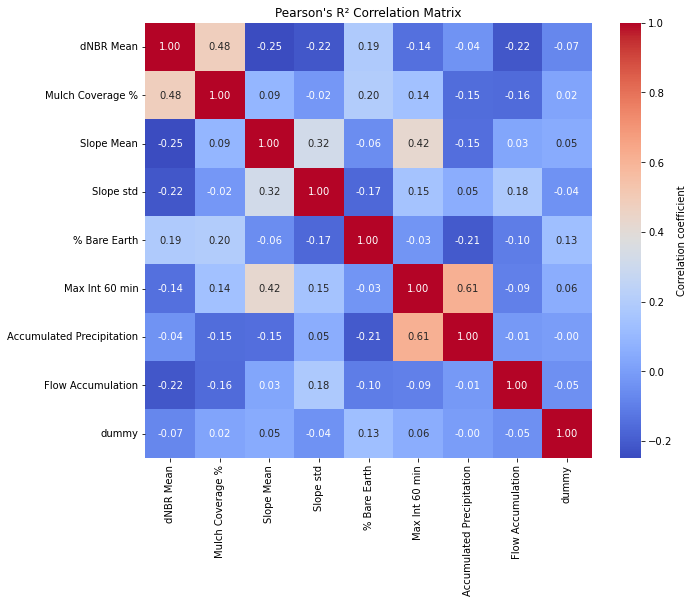

In [ ]:
from RF_lib.RF_feature_importance import correlation_matrix_table

correlation_matrix_table(X_train)

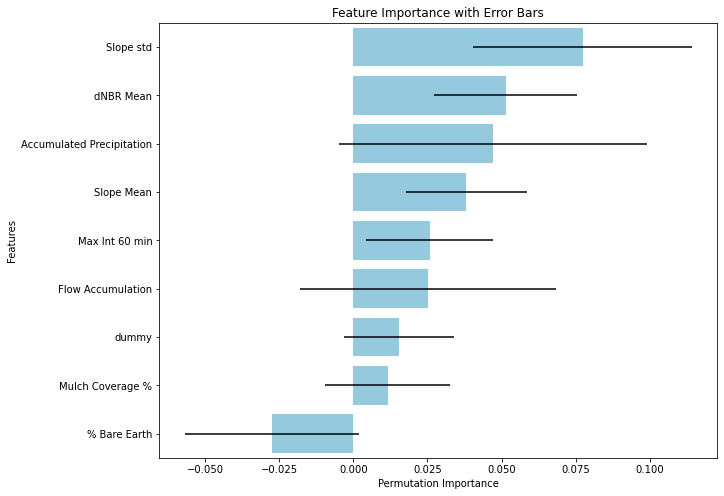

In [ ]:
from RF_lib.RF_feature_importance import plot_permutation_importance

plot_permutation_importance(model, X_test, y_test, n_repeats=30)

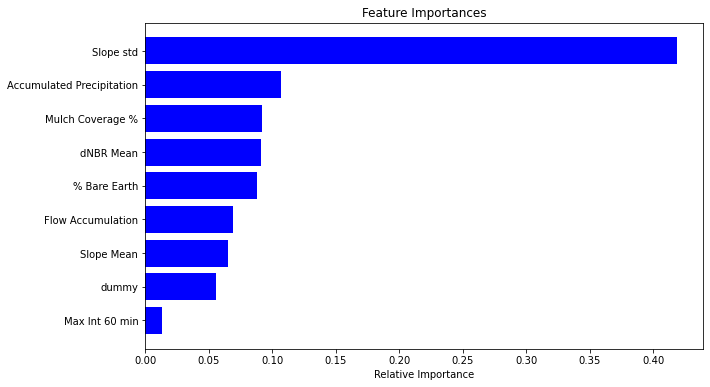

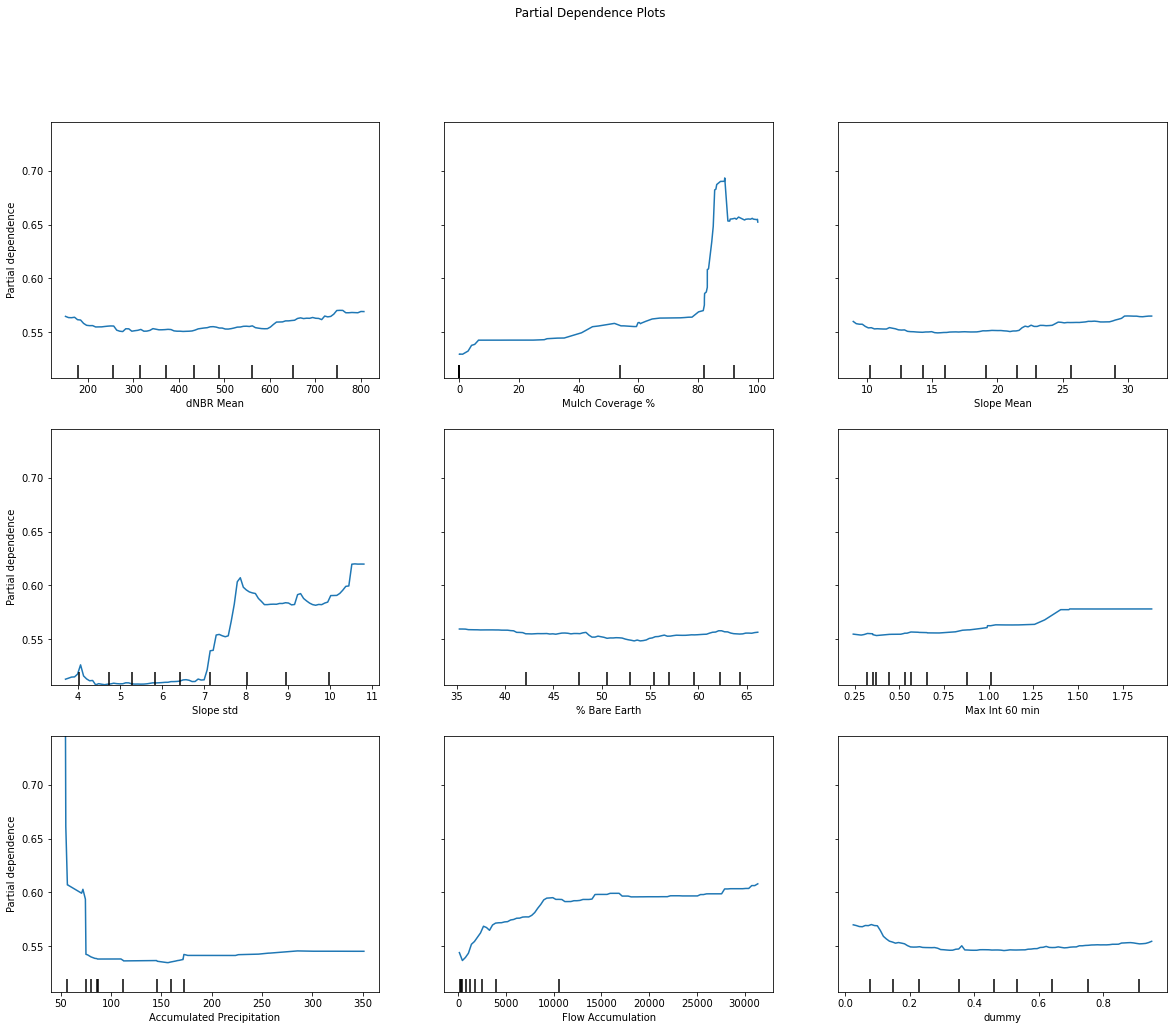

In [6]:
from RF_lib.RF_feature_importance import plot_Gini_feature_importances, partial_dependence_plots
#Gini Impurity Feature Importance Ranking
plot_Gini_feature_importances(model, X.columns)

#Partial Dependence Plots
feature_list = range(0, len(X.columns))
partial_dependence_plots(model, X_train, feature_list)

In [ ]:
from RF_lib.RF_feature_importance import evaluate_feature_with_shap
feature_labels = X.columns
for feature in feature_labels:
    evaluate_feature_with_shap(model, X_train, X_test, feature)